# Анализ рынка  компьютерных игр
**Сборный проект №4 Яндекс.Практикум - Data Science**

## Описание проекта

**Исходные данные:**

Исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

**Цель проекта:**

Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Структура проекта
* [1. Загрузка и изучение общей информации датасета](#start)
* [2. Предобработка данных](#preprocessing)
    * [2.1 Замена названий столбцов](#columns)
    * [2.2 Приведение к нужным типам](#types)
    * [2.3 Обработка пропущенных значений](#nan)
    * [2.4 Подсчёт суммарных продаж по всем регионам](#augmentation)
* [3. Исследовательский анализ данных](#eda)
* [4. Составление портрета пользователя каждого региона](#individual)
* [5. Проверка гипотез](#hypothesis)
    * [5.1 Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#platform_equal)
    * [5.2 Гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные](#genre_equal)
* [6. Общий вывод](#conclusion)

<a id="start"></a>
## 1. Загрузка и изучение общей информации датасета

#### Импортируем необходимые библиотеки

In [1]:
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# input path of datasets
PATH = input()

In [4]:
dataset_name = 'games.csv'

try:
    df = pd.read_csv(f'{PATH}{dataset_name}', sep=',')
    print(f'Прочитан файл с данными: "{PATH}{dataset_name}"')
except:
    print(repr(err))

Прочитан файл с данными: "../datasets/games.csv"


#### Изучим загруженные датасеты

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Описание данных**

Name — название игры  
Platform — платформа  
Year_of_Release (year)— год выпуска  
Genre — жанр игры  
NA_sales — продажи в Северной Америке (миллионы долларов)  
EU_sales — продажи в Европе (миллионы долларов)  
JP_sales — продажи в Японии (миллионы долларов)  
Other_sales — продажи в других странах (миллионы долларов)  
Critic_Score — оценка критиков (максимум 100)  
User_Score — оценка пользователей (максимум 10)  
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

#### Выводы:
* имеются данные по 16715 играм
* имеются пропущенные значения:
    * название игры
    * год выхода
    * жанр
    * оценка критиков
    * оценка игроков
    * рейтинг от организации ESRB
* для года выхода используется тип данных float64, а для оценки пользователей тип данных object, попробуем заменить их на этапе обрабтки данных

<a id="preprocessing"></a>
## 2. Предобработка данных

<a id="columns"></a>
### 2.1 Замена названий столбцов

Приведём все названия столбцов к нижнему регистру

In [7]:
df.columns = [x.lower() for x in df.columns]

<a id="types"></a>
### 2.2 Приведение к нужным типам

**Заменим тип данных года выхода на тип данных datetime**

In [8]:
try:
    df.loc[:, 'year_of_release'] = df['year_of_release'].astype('datetime64[Y]')
except Exception as e:
    print('Что-то пошло не так: ', str(e), sys.exc_info()[0])
else:
    print("Значения в столбце 'year_of_release' приведены к типу datetime")

Что-то пошло не так:  Out of bounds nanosecond timestamp: 3976-01-01 00:00:00 <class 'pandas._libs.tslibs.np_datetime.OutOfBoundsDatetime'>


Не получилось привести к другому типу, избавимся в начале от пропущенных значений

**Заменим тип данных user_score на вещественный тип**

In [9]:
try:
    df.loc[:, 'user_score'] = pd.to_numeric(df['user_score'], errors='raise')
except Exception as e:
    print('Что-то пошло не так:', str(e), sys.exc_info()[0])
else:
    print("Значения в столбце 'user_score' приведены к типу float")

Что-то пошло не так: Unable to parse string "tbd" at position 119 <class 'ValueError'>


Заменить на вещественный тип не получилось, так как присутствуют значения строковые 'tbd', которые согласно информации на сайте metacritic.com означают, что недостаточно оценок для отображения итоговой оценки игры.

Так как мы не можем предсказать какая оценка может быть в таком случае, то заменим 'tbd' на пропуски значений.

In [10]:
df.loc[:, 'user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

<a id="nan"></a>
### 2.3 Обработка пропущенных значений

**Проверим строки в которых пропущенно название игры**

In [11]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Удалим строки с пропущенным названием игры, так как такие данные никакой ценности не имеют. Заодно удалятся строки с пропущенным жанром, таких строк тоже было 2.

In [12]:
df = df[~df['name'].isna()]

**Обработаем строки в которых пропущен год выхода игры**

In [13]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Похоже, что в некоторых играх год выхода можно взять из названия, но не будем это делать, потому что нет никакой гарантии, что мы не ошибёмся и таким образом исказим исследование.

Избавимся от пропущенных значений и затем уже изменим тип данных.

In [14]:
df = df[~df['year_of_release'].isna()]
df.loc[:, 'year_of_release'] = pd.to_datetime(df['year_of_release'].astype(str), format='%Y.0')

**Обработаем строки в которых пропущены оценки критиков и оценки пользователей**

In [15]:
df[df['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989-01-01,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984-01-01,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005-01-01,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016-01-01,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006-01-01,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016-01-01,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003-01-01,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [16]:
df[df['user_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989-01-01,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984-01-01,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005-01-01,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016-01-01,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006-01-01,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016-01-01,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003-01-01,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


К сожалению, мы никак не можем предугадать какую оценку могли дать игре пользователи и критики, поэтому оставим пропуски как есть, но не будем их использовать в обработке, когда нам важны будут оценки игры.

**Обработам строки с рейтингом игры**

In [17]:
df[df['rating'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989-01-01,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984-01-01,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005-01-01,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016-01-01,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006-01-01,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016-01-01,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003-01-01,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


С рейтингом тоже ничего делать не будем, оставим пропуски как есть

<a id="augmentation"></a>
### 2.4 Подсчёт суммарных продаж по всем регионам

Добавим столбец с общей суммой продаж по всем регионам

In [18]:
df['overall_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

#### Вывод:
* привели названия столбцов к нижнему регистру
* year_of_release привели к типу datetime
* user_score привели к вещественному типу
* удалили 2 строки где пропущены названия игр
* удалили 269 строк где пропущен год выпуска игры (менее 2% данных)
* заменили значения оценки игры пользователями с 'tbd' на NaN
* добавили суммарные продажи по всем регионам

<a id="eda"></a>
## 3. Исследовательский анализ данных

#### Количество игр выпускавшихся в разные годы

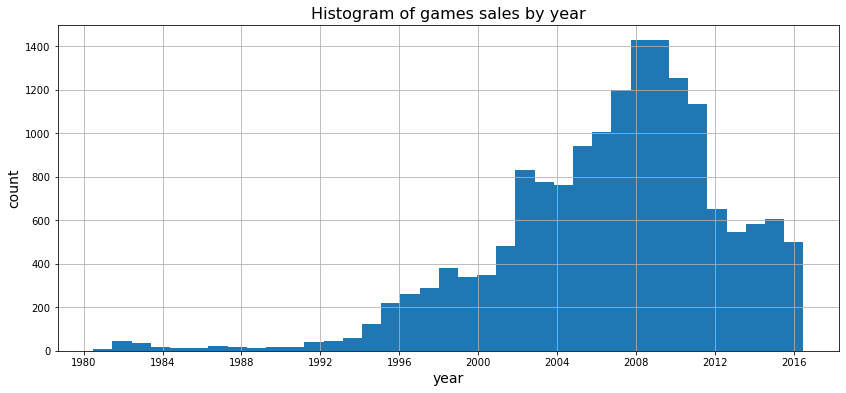

In [19]:
plt.figure(figsize=(14,6))
plt.title('Histogram of games sales by year', fontsize=16)
plt.xlabel('year', fontsize=14)
plt.ylabel("count", fontsize=14)
plt.hist(df['year_of_release'], bins=len(df['year_of_release'].unique()), align='right')
plt.grid(True)

#### Изменения продаж игр по платформам

Сформируем сводную таблицу по годам и платформам. Заполним пропуски нулями и приведёт datetime к строковому представлению года

In [20]:
table_all = df.pivot_table(values='name', index='year_of_release', columns='platform', aggfunc='count')
table_all = table_all.fillna(0.0)
table_all.index = map(lambda x: x.strftime("%Y"), table_all.index)

Напишем функци для посроения гистограмм с накоплением, чтобы графики которые мы будет строить были в едином стиле

In [21]:
def plot_stacked_bar(data=None, width=0.8, figsize=[18,10]):
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)
    bottom = [0 for x in range(len(data.index))] # bottom of bar for next platform in graph
    
    # find max y
    ymax = 0
    for year in data.index:
        if ymax < sum(data.loc[year,:]):
            ymax = sum(data.loc[year,:]) + (sum(data.loc[year,:]) * 0.05)
    
    # plot bars
    for platform in data.columns:
        ax.bar(data.index, data.loc[:, platform].values, width, label=platform, bottom=bottom)
        bottom += data.loc[:, platform].values

    ax.set_ylim([0,ymax])
    ax.set_ylabel('Sales (M$)', fontsize=14)
    ax.set_xlabel('Year of release', fontsize=14)
    ax.set_xticklabels(data.index, rotation = 45, ha="center")
    ax.set_title('Stacked bar of sales by year', fontsize=18)
    ax.legend()

    plt.show()

Построим график

<ipython-input-21-8e9432a545f3>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation = 45, ha="center")


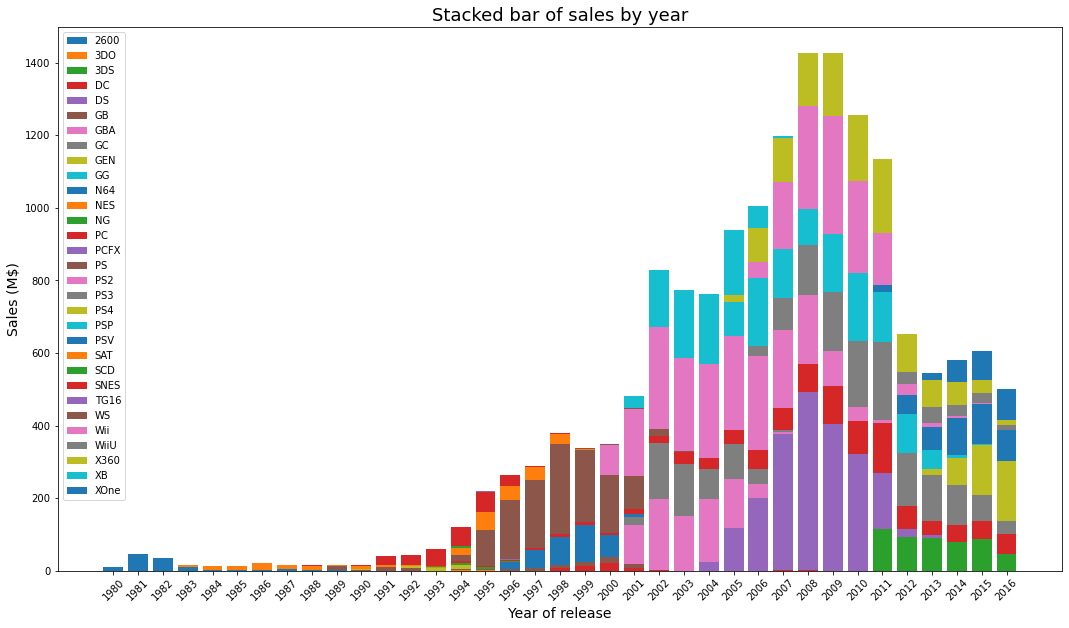

In [22]:
plot_stacked_bar(table_all)

График по всем платформам получается не очень наглядным. Выделим 10 платформ с наибольшими суммарными продажами

In [23]:
top10_platforms = set(df.groupby('platform')['overall_sales'].sum().sort_values(ascending=False).head(10).index)
print('10 самых популярных игровых платформ:', *top10_platforms)

10 самых популярных игровых платформ: DS PS4 X360 PSP PS 3DS GBA PS3 PS2 Wii


In [24]:
table_top10 = df.query('platform in @top10_platforms').pivot_table(values='name', index='year_of_release', columns='platform', aggfunc='count')
table_top10 = table_top10.fillna(0.0)
table_top10.index = map(lambda x: x.strftime("%Y"), table_top10.index)

<ipython-input-21-8e9432a545f3>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data.index, rotation = 45, ha="center")


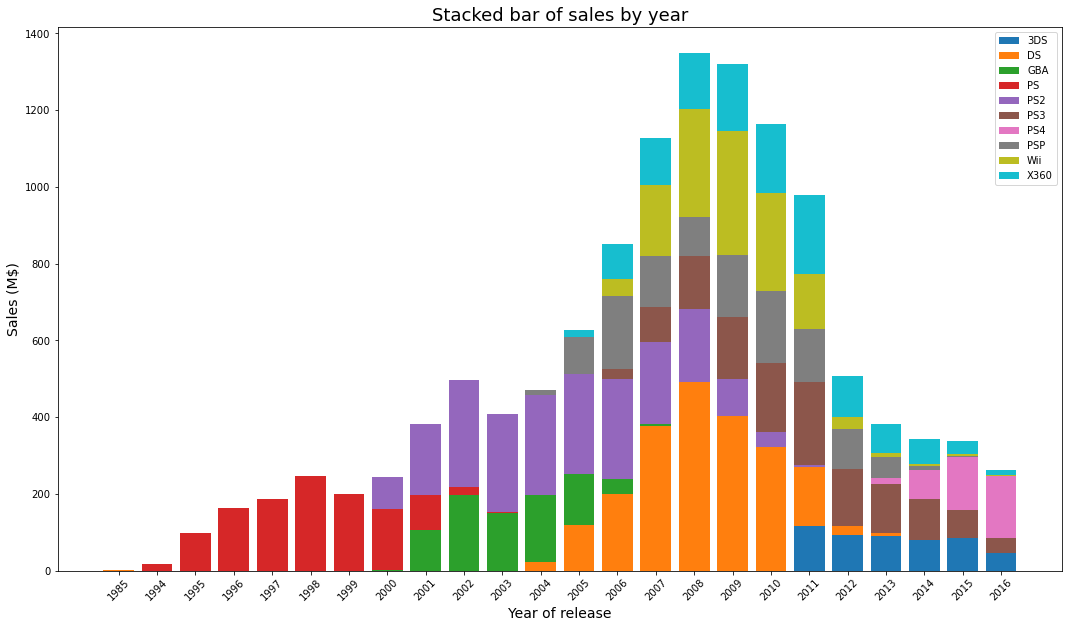

In [25]:
plot_stacked_bar(table_top10)

Проанализировав график продаж по 10 самым популярным платфорам видим, что с появлением платформы резко возрастает количество продаж игр для неё, но и, чаще всего, так же резко падают продажи через ~5 лет. Платформа "живёт" около 10 лет.
Так же видим столбец с 1985 годом для DS, что может означать, что у нас имеется в датасете разные платформы с одним именем.

Рынок платформ очень быстро меняется, поэтому брать для прогноз данные за все предыдущие годы не имеет смысла. Большую часть объёма продаж за последние годы обеспечивают несколько платформ. Рассмотрим последние **4 года**, так как в 2013 вышла на рынок самая популярная на 2016 год платформа среди топ 10 по объёму продаж за все года - PS4

In [26]:
df_actual = df.query('year_of_release >= 2013')
sales_actual_year = df_actual.pivot_table(index=['platform','year_of_release'], values='overall_sales', aggfunc='sum')
sales_actual_year.index = sales_actual_year.index.set_levels(sales_actual_year.index.levels[1].strftime("%Y"), level=1)
sales_actual_year.index = map(lambda x: ','.join(x), sales_actual_year.index.to_list())

Построим график продаж за последние 4 года по всем платформам для выявления потенциально прибыльных платформ. Для наглядности используем для каждой платформы и года отдельный столбец

<ipython-input-27-dc8369a22728>:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.bar(sales_actual_year.index, sales_actual_year.reset_index().loc[:, 'overall_sales'], width=0.8, color = my_colors)
<ipython-input-27-dc8369a22728>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sales_actual_year.index, rotation = 45, ha="right")


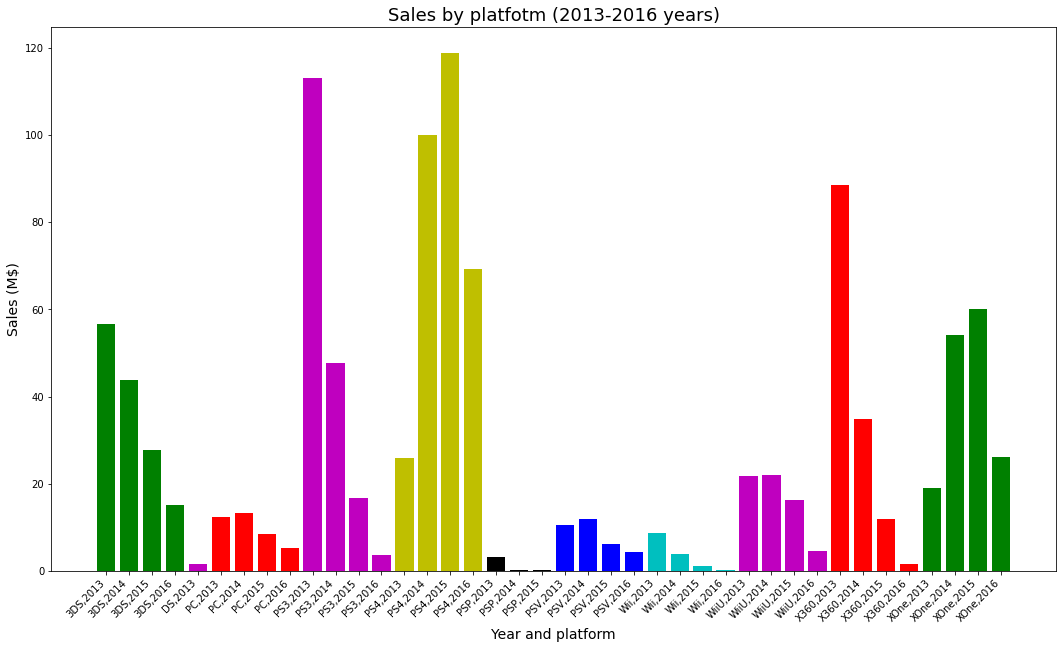

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches([18,10])
my_colors = 'ggggmrrrrmmmmyyyykkkbbbbccccmmmmrrrr'
ax.bar(sales_actual_year.index, sales_actual_year.reset_index().loc[:, 'overall_sales'], width=0.8, color = my_colors)
ax.set_title('Sales by platfotm (2013-2016 years)', fontsize=18)
ax.set_ylabel('Sales (M$)', fontsize=14)
ax.set_xlabel('Year and platform', fontsize=14)
ax.set_xticklabels(sales_actual_year.index, rotation = 45, ha="right")
plt.show()

Построим график общих продаж за последние 4 года по каждой платформе

<ipython-input-28-b9aeb1a90d5c>:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.bar(overall_sales_platforms.index, overall_sales_platforms.reset_index().loc[:, 'overall_sales'], width=0.8, color = my_colors)
<ipython-input-28-b9aeb1a90d5c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(overall_sales_platforms.index, rotation = 45, ha="right")


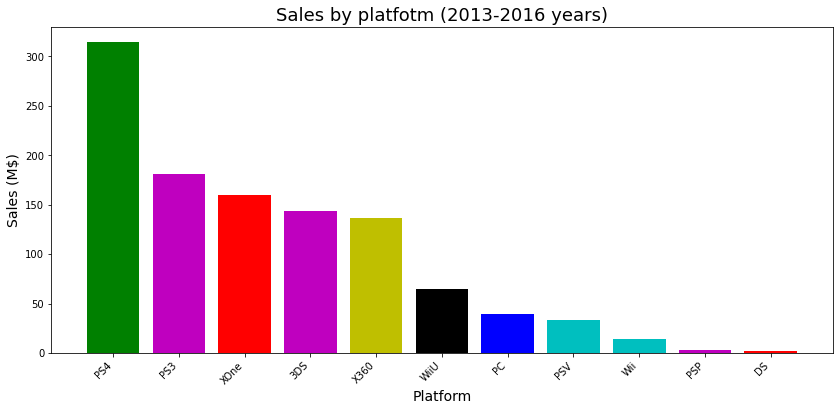

In [28]:
overall_sales_platforms = df_actual.pivot_table(index='platform', values='overall_sales', aggfunc='sum')
overall_sales_platforms = overall_sales_platforms.sort_values('overall_sales', ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches([14,6])
my_colors = 'gmrmykbccmr'
ax.bar(overall_sales_platforms.index, overall_sales_platforms.reset_index().loc[:, 'overall_sales'], width=0.8, color = my_colors)
ax.set_title('Sales by platfotm (2013-2016 years)', fontsize=18)
ax.set_ylabel('Sales (M$)', fontsize=14)
ax.set_xlabel('Platform', fontsize=14)
ax.set_xticklabels(overall_sales_platforms.index, rotation = 45, ha="right")
plt.show()

С 2013 года растут продажи XOne и PS4. Стоит отметить довольно высокую и неизменную долю продаж PC и PSV. По остальным платформам продажи либо падают, либо их доля не очень велика. Как мы видим из прошлых графиков, при появлении тенденции к падению продаж, то такая тенденция продолжается и в следующие годы. Не будем рассматривать платформы как потенциально прибыльные, если по ним уже несколько лет наблюдается спад продаж. Добавим к 4 выше отмеченным платформам 3DS, хоть падение продаж и наблюдается, но продажи всё ещё высокие.

Выделим как потенциально прибыльные платформы: **PS4, XOne, 3DS, PC, PSV**

In [29]:
selected_platforms = ['PS4', 'XOne', '3DS', 'PC', 'PSV']

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.**

In [30]:
df_actual = df[df['year_of_release'] >= '2013-01-01']
df_actual_pivot = df_actual.pivot_table(values='name', index='year_of_release', columns='platform', aggfunc='count')
df_actual_pivot = df_actual_pivot.fillna(0.0)
df_actual_pivot.index = map(lambda x: x.strftime("%Y"), df_actual_pivot.index)

In [31]:
df_actual_pivot

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
2013,91.0,8.0,38.0,126.0,16.0,54.0,63.0,12.0,42.0,75.0,19.0
2014,80.0,0.0,47.0,108.0,75.0,10.0,100.0,6.0,31.0,63.0,61.0
2015,86.0,0.0,50.0,73.0,137.0,3.0,110.0,4.0,28.0,35.0,80.0
2016,46.0,0.0,54.0,38.0,164.0,0.0,85.0,1.0,14.0,13.0,87.0


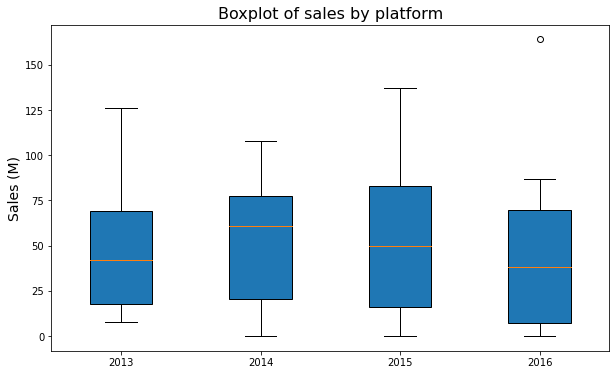

In [56]:
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_title('Boxplot of sales by platform', fontsize=16)
ax1.boxplot(df_actual_pivot.T, vert=True, patch_artist=True, labels=df_actual_pivot.index)
ax1.set_ylabel('Sales (M)', fontsize=14)
plt.show()

Среднее по продажам среди платформ к 2016 году падает, но разброс среди платформ по количеству проданных игр увеличивается, особенно это выражено в 2016 году, где есть "выброс" в сторону превышения над 3 квантилем по количеству продаж (как мы выявили ранее это - PS4).

#### Оценим влияние на продажи внутри одной популярной платформы отзывы пользователей и критиков

Выберем для исследования самую популярную платформу - **PS4**

Построим диаграмму рассеяния

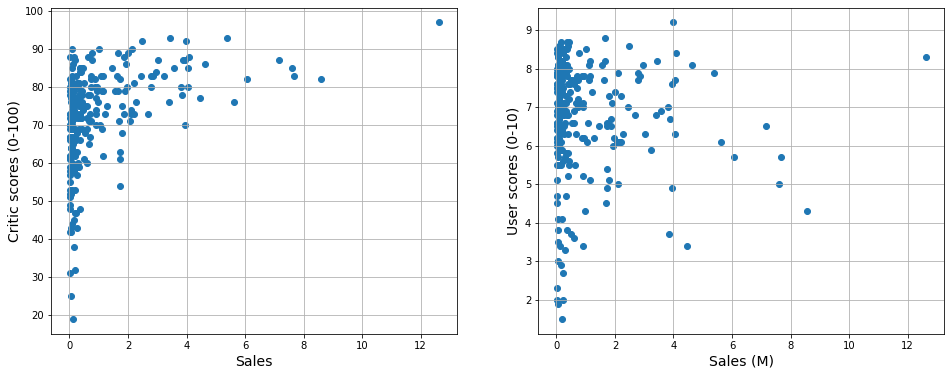

In [57]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

axs[0].scatter(
    df_actual.loc[(df_actual['platform'] == 'PS4'), 'overall_sales'],
    df_actual.loc[(df_actual['platform'] == 'PS4'), 'critic_score']
    )
axs[0].grid(True)
axs[0].set_xlabel('Sales', fontsize=14)
axs[0].set_ylabel('Critic scores (0-100)', fontsize=14)


axs[1].scatter(
    df_actual.loc[(df_actual['platform'] == 'PS4'), 'overall_sales'],
    df_actual.loc[(df_actual['platform'] == 'PS4'), 'user_score']
    )
axs[1].grid(True)
axs[1].set_xlabel('Sales (M)', fontsize=14)
axs[1].set_ylabel('User scores (0-10)', fontsize=14)

plt.show()

Посчитаем корреляцию между оценками и продажами

In [58]:
df_actual.loc[df_actual['platform'] == 'PS4', ['user_score', 'critic_score', 'overall_sales']].corr()

,user_score,critic_score,overall_sales
user_score,1.000000,0.557654,-0.031957
critic_score,0.557654,1.000000,0.406568
overall_sales,-0.031957,0.406568,1.000000


Значение корреляции между оценками критиков и продажами: 0.406568. Таким образом по оценке критиков можем предположить об успешности игры на рынке.
Значение корреляции между оценками пользователей и продажами: -0.031957. Делаем вывод, что прямой корреляции между оценками пользователей и продажами нет.

**Оценим влияние на продажи отзывы пользователей и критиков среди выбранных потенциально прибыльных платформ**

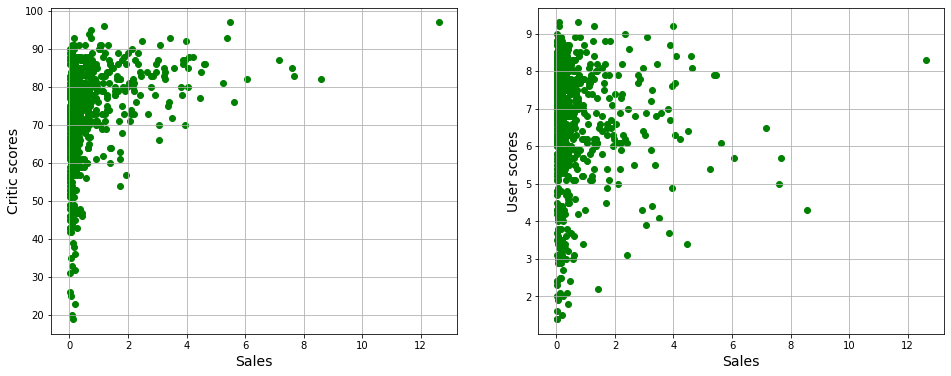

In [59]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

axs[0].scatter(
    df_actual.query('platform in @selected_platforms')['overall_sales'],
    df_actual.query('platform in @selected_platforms')['critic_score'],
    color='green')
axs[0].grid(True)
axs[0].set_xlabel('Sales', fontsize=14)
axs[0].set_ylabel('Critic scores', fontsize=14)



axs[1].scatter(
    df_actual.query('platform in @selected_platforms')['overall_sales'],
    df_actual.query('platform in @selected_platforms')['user_score'],
    color='green')
axs[1].grid(True)
axs[1].set_xlabel('Sales', fontsize=14)
axs[1].set_ylabel('User scores', fontsize=14)

plt.show()

In [60]:
df_actual.query('platform in @selected_platforms')[['user_score', 'critic_score', 'overall_sales']].corr()

,user_score,critic_score,overall_sales
user_score,1.000000,0.459529,-0.023905
critic_score,0.459529,1.000000,0.323053
overall_sales,-0.023905,0.323053,1.000000


Результаты по выбранным потенциально прибыльным платформам не отличаются от результатов полученных по самой популярной платформе PS4, заметна корреляция между оценками критиков и продажами.

**Исследуем продажи игр при распределении по жанрам**

Построим график суммы продаж по каждому жанру и кол-во выпущенных игр жанра

<ipython-input-61-7106790cfbee>:12: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax1.bar(sum_count_genres.index, sum_count_genres['sales'], width=0.8, color='gcbkym')


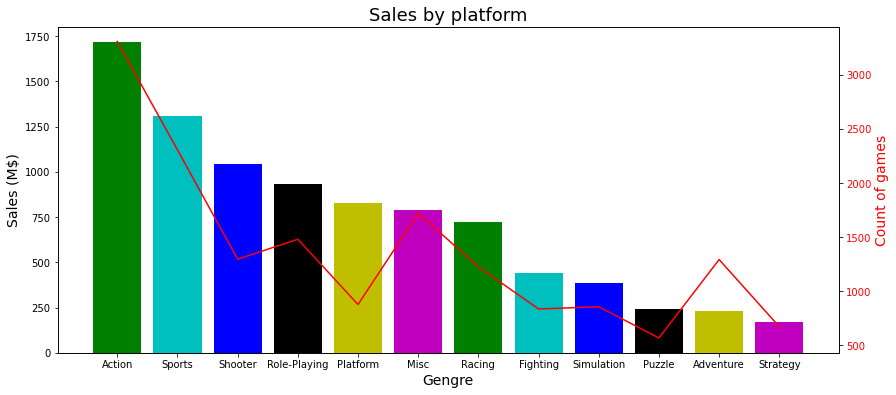

In [61]:
sum_count_genres = df.pivot_table(index='genre', values='overall_sales', aggfunc=['sum', 'count'])
sum_count_genres.columns = ['sales', 'count_games']
sum_count_genres = sum_count_genres.sort_values(by='sales', ascending=False)

fig, ax1 = plt.subplots()
fig.set_size_inches([14,6])

# Plot first
ax1.set_title('Sales by platform', fontsize=18)
ax1.set_xlabel('Gengre', fontsize=14)
ax1.set_ylabel('Sales (M$)', fontsize=14)
ax1.bar(sum_count_genres.index, sum_count_genres['sales'], width=0.8, color='gcbkym')

# Plot second
ax2 = ax1.twinx()
ax2.set_ylabel('Count of games', color='r', fontsize=14)
ax2.plot(sum_count_genres.index, sum_count_genres['count_games'], color='r')
ax2.tick_params(axis='y', labelcolor='r')


plt.show()

Средние продажи на одну игру из жанра

In [76]:
(sum_count_genres['sales'] / sum_count_genres['count_games']).sort_values(ascending=False)

genre
Platform        0.940262
Shooter         0.803519
Role-Playing    0.628683
Racing          0.590122
Sports          0.567940
Fighting        0.528865
Action          0.519057
Misc            0.459204
Simulation      0.452695
Puzzle          0.421599
Strategy        0.256419
Adventure       0.180456
dtype: float64

Отсортируем жанры по продажам на игру

In [62]:
df_actual.groupby('genre')['overall_sales'].mean().sort_values(ascending=False)

genre
Shooter         1.245882
Sports          0.703972
Platform        0.576081
Role-Playing    0.499623
Racing          0.469294
Fighting        0.441375
Action          0.420196
Misc            0.405290
Simulation      0.350968
Puzzle          0.186471
Strategy        0.180000
Adventure       0.096490
Name: overall_sales, dtype: float64

Игры жанра Action продаются ощутимо лучше, а Puzzle, Strategy, Adventure в аутсайдерах.  
По продажам на игру лидером является жанр Shooter.

#### Вывод:
* больше всего игр выпускалось с 2005 по 2010 год, потом спад и стагнация по 2016 год
* выбрали потенциально прибыльные платформы: PS4, XOne, PC, PSV, 3DS
* определили актуальный период как 4 года
* наибольшие продажи в последние годы у PS4
* выявили зависимость продаж игр от оценок критиков: чем лучше оценка, тем лучше продаётся игра с коэффициентом корреляции 0.4
* самые продаваемые и выпускаемые игра жанра Action
* определили самый прибыльный жанр - Shooter

<a id="individual"></a>
## 4. Составление портрета пользователя каждого региона

#### Найдём топ-5 платформ по продажам в каждом регионе (NA, EU, JP)

In [63]:
df_actual.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)

platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64

In [64]:
df_actual.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)

platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64

In [65]:
df_actual.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64

Предпочтения к игровым платформам в Северной Америке и Европе похожи. Отметим бОльшую популярность игровых платформ от Microsoft в Северной Америке. В Японии в топ-5 попали только платформы произведённые в Японии, и на первом месте портативная игровая платформа 3DS.

#### Найдём топ-5 популярных жанров в каждом регионе

Сравним продажи по всем жанрам

In [66]:
df_actual.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum()

,na_sales,eu_sales,jp_sales
genre,,,
Action,126.05,118.13,40.49
Adventure,7.14,8.25,5.82
Fighting,15.55,8.55,7.65
Misc,27.49,20.04,9.20
Platform,18.14,15.58,4.79
Puzzle,0.83,1.00,1.18
Racing,12.96,20.19,2.30
Role-Playing,46.40,36.97,51.04
Shooter,109.74,87.86,6.61


In [67]:
df_actual.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
genre,,,
Action,118.13,40.49,126.05
Adventure,8.25,5.82,7.14
Fighting,8.55,7.65,15.55
Misc,20.04,9.20,27.49
Platform,15.58,4.79,18.14
Puzzle,1.00,1.18,0.83
Racing,20.19,2.30,12.96
Role-Playing,36.97,51.04,46.40
Shooter,87.86,6.61,109.74


In [68]:
df_actual.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)

genre
Action          126.05
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.49
Name: na_sales, dtype: float64

In [69]:
df_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)

genre
Action          118.13
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Racing           20.19
Name: eu_sales, dtype: float64

In [70]:
df_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

genre
Role-Playing    51.04
Action          40.49
Misc             9.20
Fighting         7.65
Shooter          6.61
Name: jp_sales, dtype: float64

Существенных различий в популярных жанрах между Северной Америкой и Европой нет. В Японии, так же как и в других регионах, популярным является жанр Action, но самым популярным жанром является Role-Playing. Так же в Японии отличием оказывается наличие жанра Fighting в топ-5.

#### Исследование влияние рейтинга ESRB на продажи в отдельном регионе

Опишем значения рейтинга ESRB:
* E    - подходит всем возрастам
* E10+ - 10+ лет
* T    - 13+ лет
* M    - 17+ лет

In [71]:
grouped = df_actual.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()
for clmn in grouped.columns:
    grouped[clmn] = grouped[clmn].transform(lambda x: (x - 0) / (x.max()- 0))
grouped

,na_sales,eu_sales,jp_sales
rating,,,
E,0.478482,0.573631,0.735308
E10+,0.328309,0.293765,0.286061
M,1.000000,1.000000,0.685284
T,0.301374,0.288673,1.000000


Для удобства рассмотрения нормализуем данные, принимая максимальное значение продаж игр в регионе принимаем за 1.0.

Каких-то существенным различий в продажах по рейтингу игр межу Северной Америкой и Европой не наблюдаем, а в Японии лучше продаются игры с менее жёстким рейтингом.

#### Вывод:
* продажи игр в Японии отличается от продаж в Северной Америке и Европе:
    * в Японии предпочитают игры для платформ японских компаний
    * в Японии предпочитают RPG игры, а так же популярен жанр Fighting
    * в Японии лучше продаются игры с менее жёстким возрастным рейтингом
    * в Северной Америке и Европе наиболее популярны жанры Action и Shooter
    * существенных различий в предпочтениях в играм у пользователей в Северной Америке и Европе не выявлено

<a id="hypothesis"></a>
## 5. Проверка гипотез

Зададим предварительно уровень статистической значимости по которому будем делать вывод по проверке гипотез

In [72]:
alpha = 0.05 # критический уровень статистической значимости

<a id="platform_equal"></a>
### 5.1 Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

* Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC **ОДИНАКОВЫЕ**
* Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC **РАЗЛИЧАЮТСЯ**

In [73]:
results = st.ttest_ind(
    df_actual.loc[df_actual['platform'] == 'XOne', 'user_score'].dropna(), 
    df_actual.loc[df_actual['platform'] == 'PC',   'user_score'].dropna(),
    equal_var = False)

print('Средний пользовательский рейтинг Xbox One:', df_actual.loc[df_actual['platform'] == 'XOne', 'user_score'].mean())
print('Средний пользовательский рейтинг PC:', df_actual.loc[df_actual['platform'] == 'PC', 'user_score'].mean())

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг Xbox One: 6.521428571428572
Средний пользовательский рейтинг PC: 6.269677419354839
p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


При уровне статистической значимости в 5% мы получаем p-value около 0.14, что не даёт нам оснований отвергнуть гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Средние впользовательские рейтинги платформ Xbox One и PC близки.

<a id="genre_equal"></a>
### 5.2 Гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные

Для проверки гипотез применим метод scipy.stats.ttest_ind(), поскольку сравниваем средние двух независимых генеральных совокупностей по взятым из них выборкам

* Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports **ОДИНАКОВЫЕ**
* Альтернативная гипотеза: средние пользовательские рейтинги платформ жанров Action и Sports **РАЗЛИЧАЮТСЯ**

In [74]:
results = st.ttest_ind(
    df_actual.loc[df_actual['genre'] == 'Action', 'user_score'].dropna(), 
    df_actual.loc[df_actual['genre'] == 'Sports', 'user_score'].dropna(),
    equal_var = False)

print('Средний пользовательский рейтинг жанра Action:', df_actual.loc[df_actual['genre'] == 'Action', 'user_score'].mean())
print('Средний пользовательский рейтинг жанра Sports:', df_actual.loc[df_actual['genre'] == 'Sports', 'user_score'].mean())

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг жанра Action: 6.837532133676093
Средний пользовательский рейтинг жанра Sports: 5.238124999999999
p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Мы отвергаем гипотезу, что средние пользовательские рейтинги жанров Action и Sports одинаковые.

<a id="conclusion"></a>
## 6. Общий вывод

* Были проанализированы имеющиеся данные по играм, вышедшим с 1980 года до 2016 года включительно  
* Определили актуальный период для прогноза продаж на 2017 год: **с 2013 по 2016**  
* Определили потенциально прибыльные платформы: **PS4, XOne, 3DS, PC, PSV**
* Определили самый популярный жанр игр: **Action**
* Определили самый прибыльнй жанр игр: **Shooter**
* Были составлены портреты пользователей: 
    * В северной Америке и Европе отдают предпочтение стационарным консолям и играм в жанре Action, Shooter и Sport с рейтнгом "E" и "M",
    * В Японии предпочитают портативные игровые консоли и игры жанра Role-Playing c рейтнгом "E" и "T".
* Выявили корреляцию между оценкой критикой и успешностью продаж игры: коэффициент корреляции ~0.4
* Не выявили различий между пользовательскими рейтингами игр Xbox One и PC
* Отвергнули гипотезу, что средние пользовательские рейтинги жанров Action и Sports одинаковые